In [8]:
# import things
import numpy as np
from operator import itemgetter
import os, sys, re, random
from collections import defaultdict
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
import json

print("Imports done!")

Imports done!


In [9]:
# define utility functions

def row_norm(m):
    return np.divide(m.T, np.sum(m, axis=1)).T

def col_norm(m):
    return np.divide(m, np.sum(m, axis=0))

def safe_log(x):
    with np.errstate(divide='ignore'):
        return np.log(x)
    
def inner_product(x, y):
    return np.dot(x, y)

def powerset(x, minsize=0, maxsize=None):
    result = []
    if maxsize == None: maxsize = len(x)
    for i in range(minsize, maxsize+1):
        for val in combinations(x, i): result.append(list(val))
    return result

def mean_sq_error(x, y):
    return np.mean((x-y)**2)

def display_matrix(m, rnames=None, cnames=None, title='', digits=4):
    rwidth = 2 + max([len(x) for x in rnames] + [digits+2])
    cwidth = 2 + max([len(x) for x in cnames] + [digits+2])
    m = np.round(m, digits)
    s = ''; divider = ''; linebreak = '\n';
    for i in range(m.shape[0]):
        rowcontents = divider.join(str(x).rjust(cwidth) for x in m[i, :])
        s += str(rnames[i]).rjust(rwidth) + divider + rowcontents + linebreak
    print(s)
    
print("Utility functions done!")
    

Utility functions done!


In [10]:
# define lexicon, priors, temperatures

#propositions and null message
TT = [1.0, 1.0]; TF = [1.0, 0.0]; FT = [0.0, 1.0]
nullsem = [1.0, 1.0]

#only consider probable i.e., non-contradictory instances
lexica = [
        np.array([TT, TT, nullsem]),
        np.array([TT, TF, nullsem]),
        np.array([TT, FT, nullsem]),
        np.array([TF, TT, nullsem]),
        np.array([TF, TF, nullsem]),
        np.array([TF, FT, nullsem]),
        np.array([FT, TT, nullsem]),
        np.array([FT, TF, nullsem]),
        np.array([FT, FT, nullsem])]

#iterations for each RSA run, list of agent tuples
n = 3; agents = [];

speaker_costs = [list(np.random.rand(3)) for i in range(1, 100)];
speaker_costs = [[max(1, int(10*(i))) for i in item] for item in speaker_costs]

listener_priors = [list(np.random.rand(1)) for i in range(1, 100)];
listener_priors = [[item[0], 1-item[0]] for item in listener_priors]
   
print("Parameters done!")

Parameters done!


In [11]:
# define agent

class Module:
    def __init__(self,
                lexica=None,
                baselexicon=None,
                states=None,
                costs=None,
                messages=None,
                prior=None,
                lexprior=None,
                lexcount=None, 
                temperature=1.0,
                alpha=1.0,
                beta=1.0,
                nullmsg=True,
                nullcost=5.0):
        self.lexica = lexica
        self.baselexicon = baselexicon
        self.states = states
        self.costs = costs
        self.messages = messages
        self.prior = prior
        self.lexprior = lexprior
        self.lexcount = lexcount
        self.temperature = temperature
        self.alpha = alpha
        self.beta = beta 
        self.nullmsg = nullmsg
        self.nullcost = nullcost
        
        #intialise base prior arrays 
        if type(self.prior) == type(None):
            val = 1.0/len(self.states)
            self.prior = np.repeat(val, len(self.states))
        if type(self.lexprior) == type(None) and self.lexcount != None:
            val = 1.0/len(self.lexcount)
            self.prior = np.repeat(val, len(self.lexcount))
        else:
            self.lexprior = defaultdict(lambda: 1.0)
        if type(self.costs) == type(None):
            self.costs = np.zeros(len(self.messages))
            if self.nullmsg:
                self.costs[-1] = self.nullcost
        self.final_listener = np.zeros((len(self.messages), len(self.states)))
        self.final_speaker = None  


####  Interaction iterative functions

    def rsa(self, lex=None):
        if lex is None: lex = self.baselexicon
        literal = self.l0(lex)
        speaker = self.S(literal)
        listener = self.L(speaker)
        return [literal, speaker, listener]

    def run_base_model(self, lex, n=2, display=True, digits=4):
        return self.run(
                    n=n, 
                    display=display, 
                    digits=digits,
                    initial_listener = self.l0(lex),
                    start_level=0)

    def run(self,
       initial_listener,
       n=2,
       display=True,
       digits=4,
       start_level=0,
       ):
    #langs
        langs = [initial_listener]
        for i in range(1, (n-1)*2, 2):
            langs.append(self.S(langs[i-1]))
            langs.append(self.L(langs[i]))
        
        if len(langs) < 2:
            self.final_speaker = None
            self.final_listener = langs[-1]
        else:
            self.final_speaker, self.final_listener = langs[-2:]
        
        if display:
            self.display_iteration(langs, start_level=start_level, digits=digits)
        return langs
    

#### Agents

    def l0(self, lex):

        return row_norm(lex*self.prior)

    def L(self, speaker):
        return self.l0(speaker.T)

    def S(self, listener):
        return row_norm(np.exp(self.temperature * ((self.alpha*safe_log(listener.T)) - self.costs)))

    def s1(self, lex):
        return self.S(self.l0(lex))

    def l1(self, lex):
        return self.L(self.s1(lex))

    def lex_likelihood(self):
        p = np.array([np.sum(self.s1(lex), axis=0) * self.lexprior[i] for i, lex in enumerate(self.lexica)])
        return col_norm(p)

    def listener_lexical_marginalisation(self, listener):
        return np.sum(listener, axis=1)

    def speaker_lexical_marginalisation(self, speaker):
        return row_norm(np.sum(speaker, axis=0))

#### $\rightarrow$ Display functions

    def display_expertise_iteration(self, langs, digits=4):
        """Display the full iteration for any the expertise model"""       
        level = 1
        for index in range(0, len(langs)-1, 2):
            self.display_joint_listener_matrices(
                langs[index], level=level, digits=digits)
            self.display_listener_matrix(
                self.listener_lexical_marginalization(langs[index]),
                title="{} - marginalized".format(level),
                digits=digits)                        
            level += 1
            self.display_expert_speaker_matrices(
                langs[index+1], level=level, digits=digits)
            self.display_speaker_matrix(
                self.speaker_lexical_marginalization(langs[index+1]),
                title='{} - marginalized'.format(level),
                digits=digits)
            
    def display_iteration(self, langs, start_level=0, digits=4):
        """Display the full iteration for any model except expertise"""
        self.display_listener_matrix(
            langs[0], title=start_level, digits=digits)        
        start_level += 1
        display_funcs = (self.display_speaker_matrix,
                         self.display_listener_matrix)
        for i, lang in enumerate(langs[1: ]):
            display_funcs[i % 2](lang, title=start_level, digits=digits)
            if i % 2: start_level += 1

    def display_speaker_matrix(self, mat, title='', digits=4):
        """Pretty-printed (to stdout) speaker matrix to standard output"""
        display_matrix(
            mat,
            title='S{}'.format(title),
            rnames=self.states,
            cnames=self.messages,
            digits=digits)

    def display_listener_matrix(self, mat, title='', digits=4):
        """Pretty-printed (to stdout) listener matrix to standard output"""
        display_matrix(
            mat,
            title='L{}'.format(title),
            rnames=self.messages,
            cnames=self.states,
            digits=digits)

        
print("Agent done!")

Agent done!


In [12]:
# define listener

In [13]:
# simulations

def simulation(n):
    for i in range(len(speaker_costs)):
        for j in range(len(listener_priors)):
            speaker_cost = speaker_costs[i]
            listener_prior = listener_priors[j]

            mod = Module(
                    lexica = lexica,
                    messages=['insect', 'error', 'null'],
                    costs=np.array(speaker_cost),
                    states = ['ref_1', 'ref_2'],
                    prior=np.array(listener_prior),
                    lexprior=np.repeat(1.0/len(lexica), len(lexica)),
                    temperature=3,
                    alpha=1.0,
                    beta=1.0)

            for k in range(len(lexica)):
                lex = lexica[k]
                baselangs = mod.run_base_model(lex, n=n, display=False)
                # tuple = (speaker, listener, speaker_cost, listener_prior)
                agents.append((baselangs[-2], baselangs[-1], speaker_cost, listener_prior))

    beliefs = np.zeros((10, 10))
    count, total = 0.0, 0.0
    for i in range(n):
        print('Simulation ', i)
        rand1, rand2 = np.random.randint(len(agents)), np.random.randint(len(agents))
        #rand1, rand2 = i, i
        #if rand1 == rand2: continue
        speaker = agents[rand1][0]; listener = agents[rand2][1]
        listener_prior, speaker_cost = agents[rand2][3], agents[rand1][2]
        rand_ref = np.random.randint(2)

        # index of utterance generated by speaker
        # get speaker's prior cost for this utterance
        s_index = np.argmax(speaker[rand_ref])
        fin_cost = speaker_cost[s_index]
        # index of choice made by listener
        # get listeners prior for this choice
        l_index = np.argmax(listener[s_index])
        fin_prior = listener_prior[l_index]

        # if they coordinate or don't coordinate
        #if rand_ref != l_index:
        if rand_ref == l_index:
            count += 1
            beliefs[int(fin_cost-1)][min(9, int(round(10*fin_prior, 1)))] += 1
        total += 1
        

    print("Beliefs:'\t", beliefs)
    print("Percentage:\t", 100*count/total)
    sns.set()
    ax = sns.heatmap(beliefs, cmap="YlGnBu")
    ax.set_xlabel('Listener Prior'); ax.set_ylabel('Speaker Cost')
    plt.show()

Simulation  0
Simulation  1
Simulation  2
Simulation  3
Simulation  4
Simulation  5
Simulation  6
Simulation  7
Simulation  8
Simulation  9
Beliefs:'	 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Percentage:	 30.0


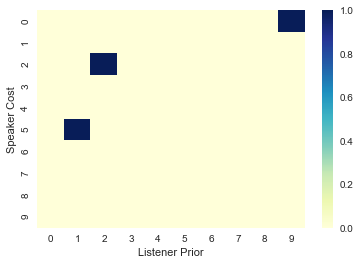

In [14]:
# define n and run

simulation(10)